In [1]:
from foundry.util.runtime import setup
setup()

import foundry.core.tree as tree
import foundry.numpy as jnp

from foundry import core as F
from foundry.core.typing import Array
from foundry.data import Data, PyTreeData
from functools import partial

In [2]:
import foundry.random

# raw_data = (jnp.array([-1., 1.]), jnp.array([-1., 1.]))
# raw_data : tuple[Array, Array] = tree.map(lambda x: jnp.repeat(x[None, :], 128, axis=0).reshape(-1), raw_data)

def sample(rng_key):
    x_rng, y_rng = foundry.random.split(rng_key)
    x = foundry.random.choice(x_rng, jnp.array([-1., 1.]))
    s = 0.1*(x + 1) + 0.05
    y = x + s*foundry.random.normal(y_rng)
    return (x, y)

def sample_val(rng_key):
    x_rng, y_rng = foundry.random.split(rng_key)
    x = foundry.random.uniform(x_rng, (), minval=-1., maxval=1.)
    s = 0.1*(x + 1) + 0.05
    y = x + s*foundry.random.normal(y_rng)
    return (x, y)

N_train = 1024
N_val = 1024
raw_data = F.vmap(sample)(foundry.random.split(foundry.random.key(42), N_train))
data = PyTreeData(raw_data)
val_raw_data = F.vmap(sample_val)(foundry.random.split(foundry.random.key(42), N_val))
val_data = PyTreeData(val_raw_data)

In [3]:
import flax.linen as nn
from foundry.models.embed import SinusoidalPosEmbed
from foundry.models import activation as activations
from typing import Any, Sequence

class DiffusionMLP(nn.Module):
    features: Sequence[int]
    activation: str = "relu"
    time_embed_dim: int = 8

    @nn.compact
    def __call__(self, cond, value,
                    # either timestep or time_embed must be passed
                    timestep=None, train=False):
        activation = getattr(activations, self.activation)
        # works even if we have multiple timesteps
        timestep_flat = tree.ravel_pytree(timestep)[0] - 1
        time_embed = F.vmap(
            lambda x: SinusoidalPosEmbed(self.time_embed_dim)(x)
        )(timestep_flat).reshape(-1)
        time_embed = nn.Sequential([
            nn.Dense(self.time_embed_dim),
            activation,
            nn.Dense(self.time_embed_dim),
        ])(time_embed)
        cond_flat = tree.ravel_pytree(cond)[0]
        cond_embed = nn.Sequential([
            nn.Dense(self.time_embed_dim),
            activation,
            nn.Dense(self.time_embed_dim),
        ])(cond_flat)

        # concatenated embedding
        value_flat, value_uf = tree.ravel_pytree(value)
        value = jnp.concatenate((value_flat,cond_flat), axis=-1)
        embed = time_embed # jnp.concatenate((time_embed,cond_embed), axis=-1)
        for feat in self.features:
            shift, scale = jnp.split(nn.Dense(2*feat)(embed), 2, -1)
            value = activation(nn.Dense(feat)(value))
            value = value * (1 + scale) + shift
        value = nn.Dense(value_flat.shape[-1])(value)
        # x = jax.nn.tanh(x)
        value = value_uf(value)
        return value

model = DiffusionMLP(features=(8, 8))

In [4]:
import optax
import foundry.train
from foundry.diffusion import DDPMSchedule

schedule = DDPMSchedule.make_squaredcos_cap_v2(
    16, 
    prediction_type="epsilon",
    clip_sample_range=2.,
)

def loss(vars, rng_key, sample):
    x, y = sample
    denoiser = lambda rng_key, noised_y, t: model.apply(vars, x, noised_y, t)
    loss = schedule.loss(rng_key, denoiser, y)
    return foundry.train.LossOutput(
        loss=loss,
        metrics={"loss": loss}
    )
batch_loss = foundry.train.batch_loss(loss)

vars = model.init(foundry.random.key(42), 
    jnp.zeros(()), jnp.zeros(()),  0
)
iterations = 50_000
optimizer = optax.adamw(
    optax.cosine_decay_schedule(5e-3, iterations),
    weight_decay=0.01
)
ema = optax.ema(0.9)
opt_state = optimizer.init(vars["params"])
ema_state = ema.init(vars)
ema_update = F.jit(ema.update)

def linear_loss(vars, rng_key, sample):
    x, y = sample
    linear_denoiser = lambda rng_key, y, t: model.apply(vars, 1., y, t)*(x+1)/2 + model.apply(vars, -1., y, t)*(1 - x)/2
    denoiser = lambda rng_key, noised_y, t: model.apply(vars, x, noised_y, t)
    t = foundry.random.randint(rng_key, (), minval=1, maxval=schedule.num_steps + 1)
    noised, _, _ = schedule.add_noise(rng_key, y, t)
    loss = jnp.mean(jnp.square(linear_denoiser(None, noised, t) - denoiser(None, noised, t)))
    return foundry.train.LossOutput(
        loss=loss,
        metrics={"loss": loss}
    )
batch_linear_loss = foundry.train.batch_loss(linear_loss)

@F.jit
def nn_sample(vars, x, rng_key):
    denoiser = lambda x, rng_key, y, t: model.apply(vars, x, y, t)
    sample = schedule.sample(rng_key, partial(denoiser, x), jnp.zeros(()))
    return x, sample

history = []
stream = data.stream().shuffle(foundry.random.key(42)).batch(1024)
with foundry.train.loop(stream, iterations=iterations, progress=False,
        rng_key=foundry.random.key(40)) as loop:
    for epoch in loop.epochs():
        for step in epoch.steps():
            opt_state, vars, metrics = foundry.train.step(batch_loss,
                optimizer, opt_state, vars, step.rng_key,
                step.batch
            )
            _, ema_state = ema_update(vars, ema_state)
            if (step.iteration + 1) % 100 == 0 or step.iteration == 0:
                test_vars = ema_state.ema
                val_metrics = foundry.train.eval(batch_loss, test_vars, step.rng_key, val_raw_data)
                val_linear_metrics = foundry.train.eval(batch_linear_loss, test_vars, step.rng_key, val_raw_data)
                train_samples = F.vmap(nn_sample, in_axes=(None, 0,0))(test_vars, raw_data[0], foundry.random.split(step.rng_key, N_train))
                val_samples = F.vmap(nn_sample, in_axes=(None, 0,0))(test_vars, val_raw_data[0], foundry.random.split(step.rng_key, N_val))
                train_sq_error = jnp.mean(jnp.square(train_samples[1] - train_samples[0])).item()
                val_sq_error = jnp.mean(jnp.square(val_samples[1] - val_samples[0])).item()
                history.append({"step": step.iteration, "loss": metrics["loss"].item(), "val_loss": val_metrics['loss'].item(),
                                "linear_val_loss": val_linear_metrics["loss"].item(),
                                "sq_error": train_sq_error, "val_sq_error": val_sq_error})
                if (step.iteration + 1) % 1000 == 0 or step.iteration == 0:
                    print(f"Iteration {step.iteration + 1}: {metrics['loss'].item()}, linear_error: {val_linear_metrics['loss']}"
                          + f" val {val_metrics['loss'].item()} sq_error: {train_sq_error} val_sq_erorr: {val_sq_error}")
vars = ema_state.ema

Iteration 1: 1.387023687362671, linear_error: 1.1017084133868593e-08 val 1.0603697299957275 sq_error: 3.527153491973877 val_sq_erorr: 2.7136878967285156
Iteration 1000: 0.16708272695541382, linear_error: 0.4345364570617676 val 0.8681581020355225 sq_error: 0.022410869598388672 val_sq_erorr: 0.21175190806388855
Iteration 2000: 0.14606401324272156, linear_error: 0.28598928451538086 val 0.632656455039978 sq_error: 0.020679816603660583 val_sq_erorr: 0.14939355850219727
Iteration 3000: 0.15694428980350494, linear_error: 0.2430785745382309 val 0.554381251335144 sq_error: 0.016536973416805267 val_sq_erorr: 0.12081241607666016
Iteration 4000: 0.15431532263755798, linear_error: 0.1837066411972046 val 0.5022024512290955 sq_error: 0.021099407225847244 val_sq_erorr: 0.1015801727771759
Iteration 5000: 0.12538176774978638, linear_error: 0.1455821543931961 val 0.41958528757095337 sq_error: 0.019727010279893875 val_sq_erorr: 0.08990910649299622
Iteration 6000: 0.13217516243457794, linear_error: 0.11350

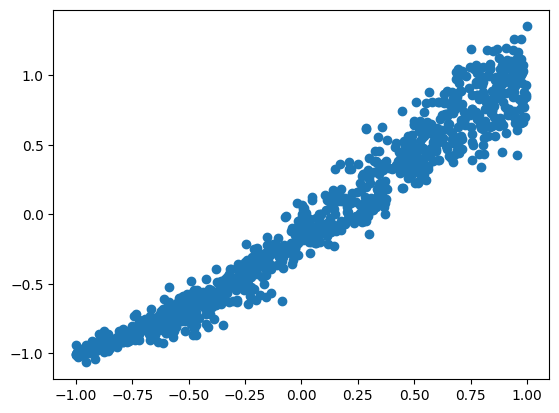

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

val_samples = F.vmap(nn_sample, in_axes=(None, 0,0))(test_vars, val_raw_data[0], foundry.random.split(step.rng_key, N_val))
plt.scatter(val_samples[0], val_samples[1])

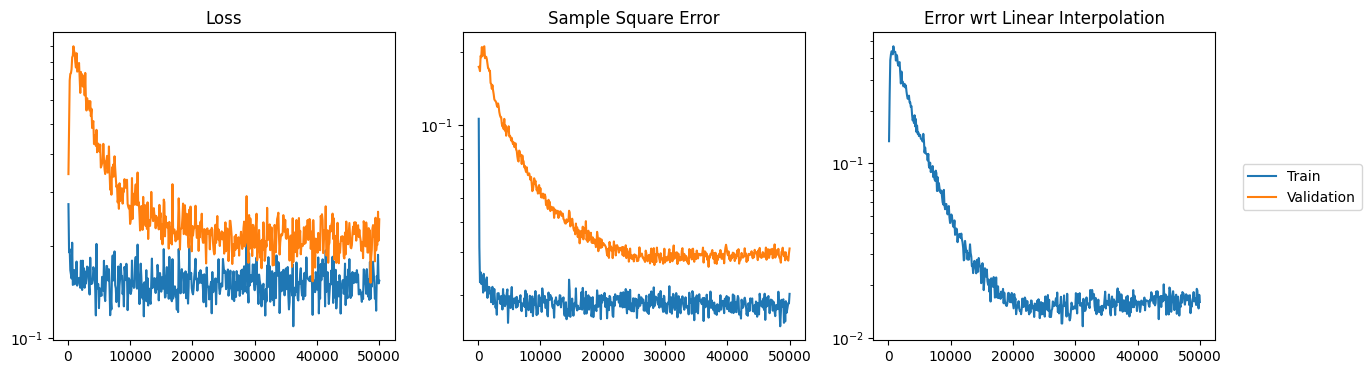

In [9]:

history_data = pd.DataFrame(history)
history_data = history_data[history_data['step'] > 0]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(4)
fig.set_figwidth(15)
ax1.plot(history_data['step'], history_data['loss'], label="Train")
ax1.plot(history_data['step'], history_data['val_loss'], label="Validation")
ax2.plot(history_data['step'], history_data['sq_error'])
ax2.plot(history_data['step'], history_data['val_sq_error'])
ax3.plot(history_data['step'], history_data['linear_val_loss'])
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax1.set_title("Loss")
ax2.set_title("Sample Square Error")
ax3.set_title("Error wrt Linear Interpolation")
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='right')
plt.show()